In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import cv2
import os

input_path = 'images/'
output_path = 'output/'
output_path_prop = output_path + 'properties/'
output_path_transf = output_path + 'transform/'

if not os.path.exists(output_path):
    os.makedirs(output_path)

if not os.path.exists(output_path_prop):
    os.makedirs(output_path_prop)

if not os.path.exists(output_path_transf):
    os.makedirs(output_path_transf)

# 1 - Medidas dos Objetos

In [ ]:
# Carregar as imagens
imagens_orig = []
for nome in sorted(os.listdir('images/prop/')):
    if nome.endswith('.png'):
        imagem = cv2.imread(f'./images/prop/{nome}', cv2.IMREAD_COLOR)
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        imagens_orig.append((imagem, nome[:-4]))

## 1.1 - Transformação de Cores

In [ ]:
imagens_pb = []
for imagem, nome in imagens_orig:
    imagem_pb = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)
    imagem_pb = np.where(imagem_pb < 255, 0, imagem_pb).astype(np.uint8)
    imagens_pb.append((imagem_pb, nome))

fig, axes = plt.subplots(len(imagens_orig), 2, figsize=(20, 20))
for i, (imagem, nome) in enumerate(imagens_orig):
    axes[i, 0].imshow(imagem)
    axes[i, 0].set_title(f'Imagem Original: {nome}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(imagens_pb[i][0], cmap='gray')
    axes[i, 1].set_title(f'Imagem em Escala de Cinza: {nome}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.savefig(output_path_prop + 'imagens_orig_gray.png')
plt.show()

## 1.2 - Contornos dos Objetos

In [ ]:
imagens_contornos = []
for imagem, nome in imagens_pb:
    contornos, _ = cv2.findContours(255 - imagem, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    imagem_contornos = np.ones_like(imagem)
    print(f'Contornos encontrados: {len(contornos)} para a imagem {nome}')
    cv2.drawContours(imagem_contornos, contornos, -1, 0, 1)
    imagens_contornos.append((imagem_contornos, nome))
    plt.show()

fig, axes = plt.subplots(len(imagens_contornos), 2, figsize=(20, 20))
for i, ((imagem_contornos, nome), (imagem_pb, _)) in enumerate(zip(imagens_contornos, imagens_pb)):
    axes[i, 0].imshow(imagem_pb, cmap='gray')
    axes[i, 0].set_title(f'Imagem em Escala de Cinza: {nome}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(imagem_contornos, cmap='gray')
    axes[i, 1].set_title(f'Contornos: {nome}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.savefig(output_path_prop + 'contornos.png')
plt.show()

## 1.3 - Extração de Propriedades do Objetos

In [ ]:
fig, axes = plt.subplots(len(imagens_pb), 2, figsize=(20, 20))

for i, ((imagem_contornos, nome), (imagem_pb, _)) in enumerate(zip(imagens_contornos, imagens_pb)):
    label_img = label(255 - imagem_pb, connectivity=2)
    regioes = regionprops(label_img)
    print(f"Propriedades da imagem {nome}:")
    
    image_label_overlay = label2rgb(label_img, image=imagem_pb, bg_label=0)
    axes[i, 0].imshow(imagem_contornos, cmap='gray')
    axes[i, 0].set_title(f'Contornos: {nome}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(image_label_overlay)
    for reg in regioes:
        print(f"  Região: {reg.label}, Perímetro: {reg.perimeter:.6f}, Área: {reg.area:.0f}")
        y, x = reg.centroid
        axes[i, 1].text(x, y, str(reg.label), color="white", fontsize=18, weight="bold", ha="center", va="center")
    axes[i, 1].set_title(f'Imagem com Regiões Rotuladas: {nome}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.savefig(output_path_prop + 'regioes.png')
plt.show()

## 1.4 - Histograma de Área dos Objetos

In [ ]:
areas = []
thr_pm = 1500
thr_mg = 3000

for i, (imagem_pb, nome) in enumerate(imagens_pb):
    label_img = label(255 - imagem_pb, connectivity=2)
    regioes = regionprops(label_img)
    areas.append((nome, [reg.area for reg in regioes]))

histogramas = []
for nome, area in areas:
    area = np.array(area)
    hist_p = np.count_nonzero(area < thr_pm)
    hist_m = np.count_nonzero((thr_pm <= area) & (area < thr_mg))
    hist_g = np.count_nonzero(area >= thr_mg)
    histogramas.append((nome, hist_p, hist_m, hist_g))

fig, axes = plt.subplots(len(histogramas), 1, figsize=(10, 5 * len(histogramas)))

for i, (nome, hist_p, hist_m, hist_g) in enumerate(histogramas):
    print(f'Número de Regiões na imagem {nome}: Pequenas: {hist_p}, Médias: {hist_m}, Grandes: {hist_g}')
    valores = [hist_p, hist_m, hist_g]
    categorias = ['P', 'M', 'G']
    cores = ['blue', 'orange', 'green']

    axes[i].bar(categorias, valores, color=cores)
    axes[i].set_title(f'Histograma de Áreas: {nome}')
    axes[i].set_xlabel('Categorias')
    axes[i].set_ylabel('Número de Objetos')

    max_val = max(valores)
    axes[i].set_ylim(0, max_val + 1)

    for j, val in enumerate(valores):
        axes[i].text(j, val + 0.1, str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path_prop + 'histogramas_areas.png')
plt.show()

# 2 - Transformações Geométricas

In [146]:
nome = "seagull"
imagem = cv2.imread(f"./images/transf/{nome}.png", cv2.IMREAD_GRAYSCALE)

In [154]:
def matriz_escala(x : float = 1, y : float = 1, inverse : bool = False) -> np.ndarray:
    matriz = np.array([[x, 0, 0],
                       [0, y, 0],
                       [0, 0, 1]])
    return np.linalg.inv(matriz) if inverse else matriz

def matriz_rotacao(angulo : float = 0, inverse : bool = False) -> np.ndarray:
    angulo_rad = np.deg2rad(-angulo)
    matriz = np.array([[np.cos(angulo_rad), -np.sin(angulo_rad), 0],
                       [np.sin(angulo_rad), np.cos(angulo_rad), 0],
                       [0, 0, 1]])
    return np.linalg.inv(matriz) if inverse else matriz

def matriz_translacao(tx : float = 0, ty : float = 0, inverse : bool = False) -> np.ndarray:
    matriz = np.array([[1, 0, tx],
                       [0, 1, ty],
                       [0, 0, 1]])
    return np.linalg.inv(matriz) if inverse else matriz
def nova_dimensao(imagem : np.ndarray, matriz_op: np.ndarray, matriz_trl: np.ndarray = None, ) -> np.ndarray:
    pontos_orig = np.array([[0, 0, 1],
                     [imagem.shape[1] - 1, 0, 1],
                     [0, imagem.shape[0] - 1, 1],
                     [imagem.shape[1], imagem.shape[0], 1]]).T
    if matriz_trl is not None:
        pontos_orig = matriz_trl @ pontos_orig
        pontos_transf = matriz_op @ pontos_orig
        pontos_transf = np.linalg.inv(matriz_trl) @ pontos_transf
    else:
        pontos_transf = matriz_op @ pontos_orig
    min_x = np.min(pontos_transf[0])
    min_y = np.min(pontos_transf[1])
    max_x = np.max(pontos_transf[0])
    max_y = np.max(pontos_transf[1])
    largura = int(max_x - min_x)
    altura = int(max_y - min_y)
    return altura, largura

def preparo(imagem: np.ndarray, angulo : float = None, escala_x : float = None, escala_y : float = None ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if angulo is not None:
        matriz_op_dir = matriz_rotacao(angulo)
        matriz_op_inv = matriz_rotacao(angulo, inverse=True)
        matriz_trl_dir = matriz_translacao(-imagem.shape[1] // 2, -imagem.shape[0] // 2)
        matriz_trl_inv = matriz_translacao(-imagem.shape[1] // 2, -imagem.shape[0] // 2, inverse=True)
    elif escala_x is not None and escala_y is not None:
        matriz_op_dir = matriz_escala(escala_x, escala_y)
        matriz_op_inv = matriz_escala(escala_x, escala_y, inverse=True)
    
    nova_altura, nova_largura = nova_dimensao(imagem, matriz_op = matriz_op_dir, matriz_trl = matriz_trl_dir if angulo is not None else None)

    imagem1 = np.zeros_like(imagem)
    if imagem.ndim == 2:
        imagem2 = np.zeros((nova_altura, nova_largura), dtype=np.uint8)
    elif imagem.ndim == 3:
        imagem2 = np.zeros((nova_altura, nova_largura, imagem.shape[-1]), dtype=np.uint8)
    
    if angulo is not None:
        matriz_op = matriz_trl_inv @ matriz_op_inv @ matriz_trl_dir
        matriz_op = matriz_trl_inv @ matriz_op_inv @ matriz_translacao(nova_largura // 2, nova_altura // 2, inverse=True)

    else:
        matriz_op = matriz_op_inv
    return imagem1, imagem2, matriz_op


## 2.1 - Interpolação pelo Vizinho Mais Próximo

In [155]:
def inter_prox(imagem: np.ndarray, angulo : float = None, escala_x : float = None, escala_y : float = None ) -> list[np.ndarray, np.ndarray]:
    
    imagem1, imagem2, matriz_op = preparo(imagem, angulo, escala_x, escala_y)
    
    for y in range(imagem1.shape[0]):
        for x in range(imagem1.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]

            if 0 <= x_lin < imagem.shape[1] and 0 <= y_lin < imagem.shape[0]:
                imagem1[y, x] = imagem[y_lin, x_lin]


    for y in range(imagem2.shape[0]):
        for x in range(imagem2.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]

            if 0 <= x_lin < imagem.shape[1] and 0 <= y_lin < imagem.shape[0]:
                imagem2[y, x] = imagem[y_lin, x_lin]
    return imagem1, imagem2


## 2.2 Interpolação Bilinear

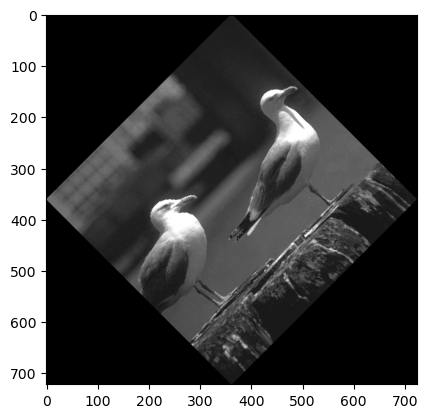

In [161]:
def inter_bilinear(imagem: np.ndarray, angulo : float = None, escala_x : float = None, escala_y : float = None ) -> list[np.ndarray, np.ndarray]:
    
    imagem1, imagem2, matriz_op = preparo(imagem, angulo, escala_x, escala_y)
    
    for y in range(imagem1.shape[0]):
        for x in range(imagem1.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]
            
            dx = x_lin % 1
            dy = y_lin % 1

            x1 = int(np.floor(x_lin))
            x2 = int(np.ceil(x_lin))
            y1 = int(np.floor(y_lin))
            y2 = int(np.ceil(y_lin))
            if 0 <= x1 and x2 < imagem.shape[1] and 0 <= y1 and y2 < imagem.shape[0]:
                v1 = (1-dx)*(1-dy) * imagem[y1, x1]
                v2 = dx*(1-dy) * imagem[y1, x2]
                v3 = (1-dx)*dy * imagem[y2, x1]
                v4 = dx*dy * imagem[y2, x2]
                imagem1[y, x] = v1 + v2 + v3 + v4

    for y in range(imagem2.shape[0]):
        for x in range(imagem2.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]
            
            dx = x_lin % 1
            dy = y_lin % 1

            x1 = int(np.floor(x_lin))
            x2 = int(np.ceil(x_lin))
            y1 = int(np.floor(y_lin))
            y2 = int(np.ceil(y_lin))
            if 0 <= x1 and x2 < imagem.shape[1] and 0 <= y1 and y2 < imagem.shape[0]:
                v1 = (1-dx)*(1-dy) * imagem[y1, x1]
                v2 = dx*(1-dy) * imagem[y1, x2]
                v3 = (1-dx)*dy * imagem[y2, x1]
                v4 = dx*dy * imagem[y2, x2]
                imagem2[y, x] = v1 + v2 + v3 + v4

    return imagem1, imagem2

plt.imshow(inter_bilinear(imagem, angulo=45)[1], cmap='gray')


## 2.3 - Interpolação Bicúbica

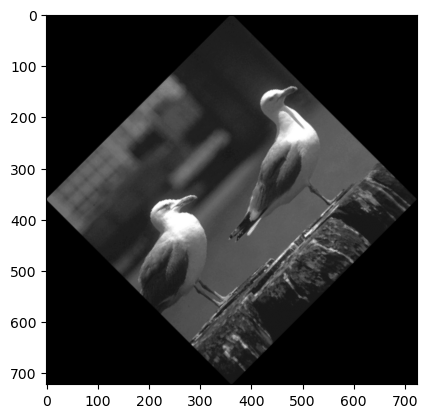

In [164]:
def P(t: float) -> float:
    if t <= 0:
        return 0
    else:
        return t

def R(s: float)-> float:
    return (1/6)*((P(s+2))**3 - 4*(P(s+1))**3 + 6*(P(s))**3 - 4*(P(s-1))**3)
    

def inter_cubica(imagem: np.ndarray, angulo : float = None, escala_x : float = None, escala_y : float = None ) -> list[np.ndarray, np.ndarray]:
    imagem1, imagem2, matriz_op = preparo(imagem, angulo, escala_x, escala_y)
    
    for y in range(imagem1.shape[0]):
        for x in range(imagem1.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]
            dx = x_lin % 1
            dy = y_lin % 1
            x1 = int(np.floor(x_lin))
            y1 = int(np.floor(y_lin))

            valor_f = 0
            for m in range(-1, 3):
                for n in range(-1, 3):
                    x_m = x_lin + m
                    y_n = y_lin + n
                    if 0 <= x_m < imagem.shape[1] and 0 <= y_n < imagem.shape[0]:
                        valor_f += imagem[y_n, x_m] * R(m - dx) * R(dy - n)
            imagem1[y, x] = valor_f
    
    for y in range(imagem2.shape[0]):
        for x in range(imagem2.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]
            dx = x_lin % 1
            dy = y_lin % 1
            x1 = int(np.floor(x_lin))
            y1 = int(np.floor(y_lin))

            valor_f = 0
            for m in range(-1, 3):
                for n in range(-1, 3):
                    x_m = x_lin + m
                    y_n = y_lin + n
                    if 0 <= x_m < imagem.shape[1] and 0 <= y_n < imagem.shape[0]:
                        valor_f += imagem[y_n, x_m] * R(m - dx) * R(dy - n)
            imagem2[y, x] = valor_f
    
    return imagem1, imagem2

plt.imshow(inter_cubica(imagem, angulo=45)[1], cmap='gray')

## 2.4 - Interpolação por Polinômios de Lagrange

In [ ]:
def L(n: int, imagem: np.ndarray, dx: float, dy: float, x: int, y: int) -> float:
    v1 = -dx*(dx-1)*(dx-2)*imagem[y + n - 2, x -1]/6
    v2 = (dx+1)*(dx-1)*(dx-2)*imagem[y + n - 2, x]/2
    v3 = -dx*(dx+1)*(dx-2)*imagem[y + n - 2, x + 1]/2
    v4 = dx*(dx+1)*(dx-1)*imagem[y + n - 2, x + 2]/6
    return v1 + v2 + v3 + v4

def inter_lagrange(imagem: np.ndarray, angulo : float = None, escala_x : float = None, escala_y : float = None ) -> list[np.ndarray, np.ndarray]:
    imagem1, imagem2, matriz_op = preparo(imagem, angulo, escala_x, escala_y)
    
    for y in range(imagem1.shape[0]):
        for x in range(imagem1.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]
            dx = x_lin % 1
            dy = y_lin % 1
            x1 = int(np.floor(x_lin))
            y1 = int(np.floor(y_lin))

            if 0 <= x1-1 and x1 + 2 < imagem.shape[1] and 0 <= y1 -1 and y1 + 2 < imagem.shape[0]:
                v1 = -dy*(dy-1)*(dy-2)*L(n=1, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/6
                v2 = (dy+1)*(dy-1)*(dy-2)*L(n=2, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/2
                v3 = -dy*(dy+1)*(dy-2)*L(n=3, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/2
                v4 = dy*(dy+1)*(dy-1)*L(n=4, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/6
                imagem1[y, x] = v1 + v2 + v3 + v4
    
    for y in range(imagem2.shape[0]):
        for x in range(imagem2.shape[1]):
            pontos = np.array([x, y, 1])
            pontos_transf = matriz_op @ pontos

            pontos_transf = np.round(pontos_transf).astype(int)

            x_lin, y_lin = pontos_transf[0], pontos_transf[1]
            dx = x_lin % 1
            dy = y_lin % 1
            x1 = int(np.floor(x_lin))
            y1 = int(np.floor(y_lin))

            if 0 <= x1-1 and x1 + 2 < imagem.shape[1] and 0 <= y1 -1 and y1 + 2 < imagem.shape[0]:
                v1 = -dy*(dy-1)*(dy-2)*L(n=1, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/6
                v2 = (dy+1)*(dy-1)*(dy-2)*L(n=1, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/2
                v3 = -dy*(dy+1)*(dy-2)*L(n=1, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/2
                v4 = dy*(dy+1)*(dy-1)*L(n=1, imagem=imagem, dx=dx, dy=dy, x=x1, y=y1)/6
                imagem2[y, x] = v1 + v2 + v3 + v4
    return imagem1, imagem2


plt.imshow(inter_lagrange(imagem, angulo=45)[1], cmap='gray')

IndexError: index 512 is out of bounds for axis 1 with size 512

In [158]:
print(1.6666 % 1)
print(1.6666 // 1)
print(1.3333 % 1)
print(1.3333 // 1)

0.6666000000000001
1.0
0.33329999999999993
1.0
